# Flowers images segmentation with Dask

In [2]:
from os import path
import numpy as np
from dask import array as darr
from dask_image import imread, ndmeasure
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)

## I. Loading pictures into Dask Array  
We load the 210 flower pictures into a 4 dimensional Dask Array (210, 128, 128, 4) spread over 210 Chunks.

In [3]:
flowersArr = imread.imread(path.join("../../data/flower_images/flower_images/", "*.png"))
flowersArr

,Array,Chunk
Bytes,13.76 MB,65.54 kB
Shape,"(210, 128, 128, 4)","(1, 128, 128, 4)"
Count,420 Tasks,210 Chunks
Type,uint8,numpy.ndarray


The following operations are implemented as per 1 block routines + a Dask Block Mapping for a distributed parallelization over all array chunks.

## II. Grayscale Filtering  
To simplify the segmentation along on channel, we gather the RGB channels into one weighted GrasyScale representation.

In [4]:
def grayscale(img, grayWeights = (0.3,0.4,0.3)):
    result = ((img[..., 0] * grayWeights[0]) +
              (img[..., 1] * grayWeights[1]) +
              (img[..., 2] * grayWeights[2]))
    return result

,Array,Chunk
Bytes,27.53 MB,131.07 kB
Shape,"(210, 128, 128)","(1, 128, 128)"
Count,2100 Tasks,210 Chunks
Type,float64,numpy.ndarray


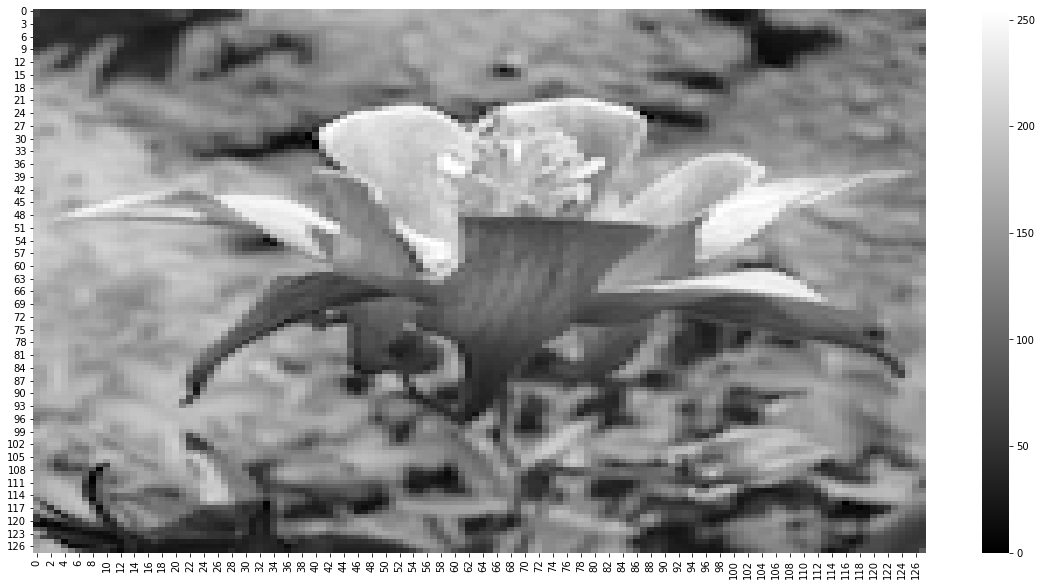

In [5]:
flowersGrayArr = grayscale(flowersArr)
sns.heatmap(flowersGrayArr[40], cmap='gray')
flowersGrayArr

## III. Segmentation  
Segmentation consists of a global thresholding that results in a binarization of the input image. The 2 category areas (0 and 1) can then be used for seperate regions labeling.

In [6]:
def segment(block, percThresh = 0.75, verbose = False):
    threshVal = percThresh*darr.max(block).compute()
    if verbose:
        print("Thresh Value : ",threshVal)
    return block > (threshVal)

,Array,Chunk
Bytes,3.44 MB,16.38 kB
Shape,"(210, 128, 128)","(1, 128, 128)"
Count,2310 Tasks,210 Chunks
Type,bool,numpy.ndarray


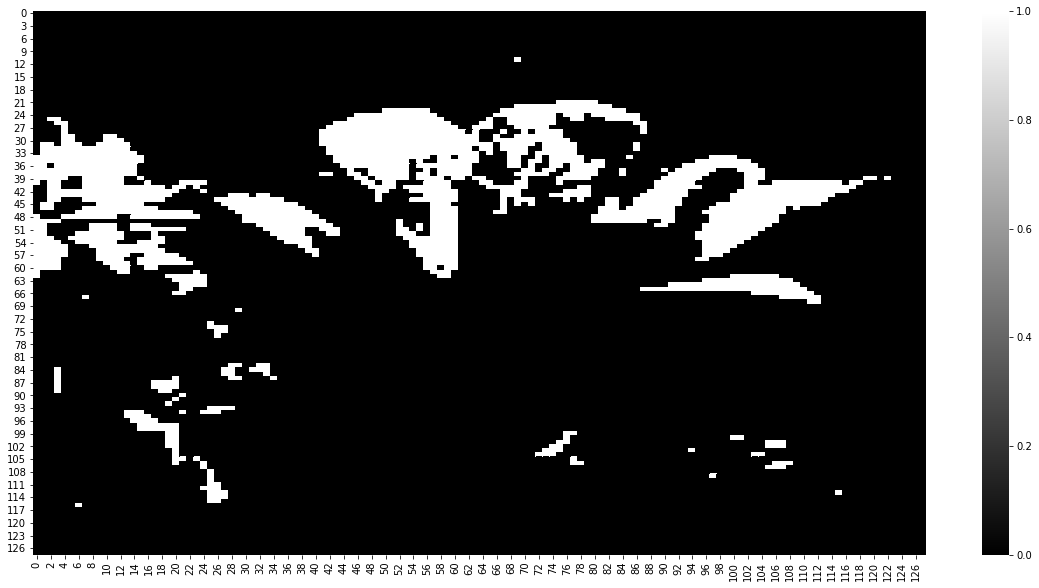

In [7]:
segmentedArr = flowersGrayArr.map_blocks(segment, verbose=False)
sns.heatmap(segmentedArr[40], cmap='gray')
segmentedArr

## IV. Labeling Segmented Regions  
The resulting segmentation can be labeled for each region of connected pixels above the threshold value used for segmentation. 

,Array,Chunk
Bytes,13.76 MB,65.54 kB
Shape,"(210, 128, 128)","(1, 128, 128)"
Count,2520 Tasks,210 Chunks
Type,int32,numpy.ndarray


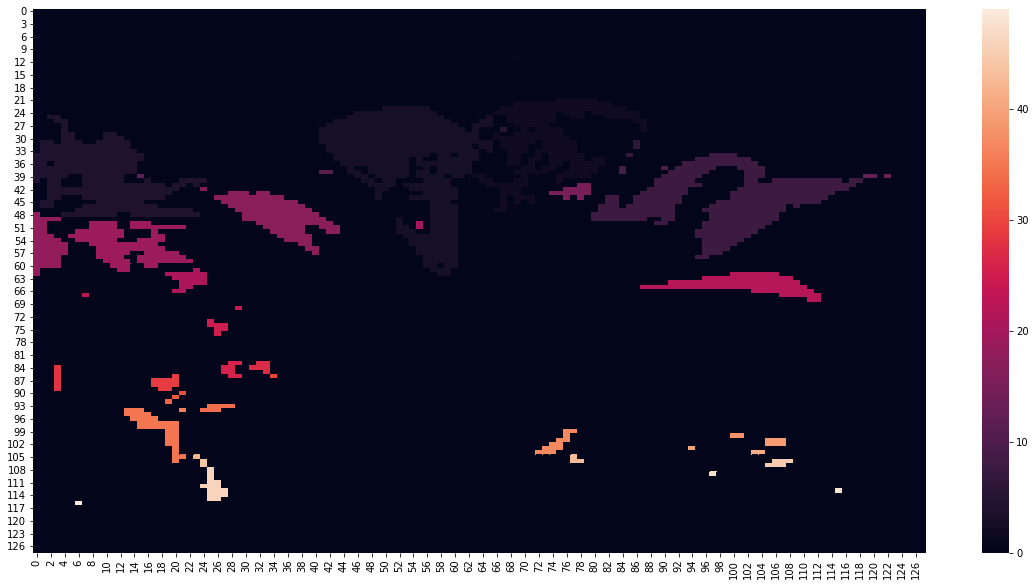

In [8]:
labeledArr = segmentedArr.map_blocks(lambda x: ndmeasure.label(x)[0])
sns.heatmap(labeledArr[40])
labeledArr